In [8]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from datetime import date
from datetime import timedelta
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = 16, 10

In [9]:
base_path = 'csse_covid_19_data/csse_covid_19_daily_reports/'

start = date.fromisoformat('2020-02-29')
#start = date.fromisoformat('2020-03-22')
end = date.today()

df_all = pd.DataFrame(columns=['FIPS', 'Admin2', 'Province_State', 'Country_Region', 'Last_Update',
                              'Lat', 'Long_', 'Confirmed', 'Deaths', 'Recovered', 'Active', 'Combined_Key'])

def rename_column_if_exists(df, old_col_name, new_col_name):
    if old_col_name in df.columns:
        df.rename(columns = {old_col_name: new_col_name}, inplace=True)
        
def str_join(df, sep, *cols):
    from functools import reduce
    return reduce(lambda x, y: x.astype(str).str.cat(y.astype(str), sep=sep), 
                    [df[col] for col in cols])

def create_combined_key_if_missing(df):
    if not 'Combined_Key' in df.columns:
        df.insert(len(df.columns), 'Combined_Key', np.NaN)
    df_missing = df['Combined_Key'].isna()
    df.loc[df_missing,'Combined_Key'] = df.loc[df_missing,:].Province_State.astype(str).str.cat(df.loc[df_missing,:].Country_Region.astype(str), sep=', ', na_rep='')
    
d = end - start
print(d.days)
for dayindex in range(0,d.days+1):
    day = start + timedelta(days=dayindex)
    filename = '{:%m-%d-%Y}'.format(day)
    #print(base_path + filename + '.csv')
    df_input = pd.read_csv(base_path + filename + '.csv')
    rename_column_if_exists(df_input, 'Province/State', 'Province_State')
    rename_column_if_exists(df_input, 'Country/Region', 'Country_Region')
    rename_column_if_exists(df_input, 'Last Update', 'Last_Update')
    rename_column_if_exists(df_input, 'Latitude', 'Lat')
    rename_column_if_exists(df_input, 'Longitude', 'Long_')
    create_combined_key_if_missing(df_input)
    df_all = df_all.append(df_input)
    
df_all['Last_Update'] = pd.to_datetime(df_all.Last_Update)
    
df_all.loc[df_all['Province_State']=='California',:]


#df_raw = pd.read_csv('csse_covid_19_data/csse_covid_19_daily_reports/03-30-2020.csv')
#df_raw.head(30)

31


,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key
40,NaN,NaN,California,US,2020-03-10 19:13:28,36.116200,-119.681600,144,2,2,NaN,"California, US"
39,NaN,NaN,California,US,2020-03-11 23:53:03,36.116200,-119.681600,177,3,2,NaN,"California, US"
37,NaN,NaN,California,US,2020-03-12 23:44:33,36.116200,-119.681600,221,4,6,NaN,"California, US"
175,NaN,NaN,California,US,2020-03-11 20:00:00,36.116203,-119.681564,282,4,6,NaN,"California, US"
32,NaN,NaN,California,US,2020-03-14 22:13:32,36.116200,-119.681600,340,5,6,NaN,"California, US"
...,...,...,...,...,...,...,...,...,...,...,...,...
1914,6109,Tuolumne,California,US,2020-03-31 23:43:56,38.026440,-119.952509,2,0,0,0,"Tuolumne, California, US"
1930,NaN,Unassigned,California,US,2020-03-31 23:43:56,0.000000,0.000000,0,0,0,0,"Unassigned, California, US"
1987,6111,Ventura,California,US,2020-03-31 23:43:56,34.444657,-119.091061,126,4,0,0,"Ventura, California, US"
2162,6113,Yolo,California,US,2020-03-31 23:43:56,38.682789,-121.901829,24,1,0,0,"Yolo, California, US"


In [22]:
df = df_all.drop(labels=['FIPS', 'Lat', 'Long_'], axis=1)
df = df.melt(id_vars=['Admin2', 'Province_State', 'Country_Region', 'Combined_Key', 'Last_Update'],
            var_name='Metric',
            value_name='Value')
df = df.set_index('Last_Update')
df.head()

,Admin2,Province_State,Country_Region,Combined_Key,Metric,Value
Last_Update,,,,,,
2020-02-29 12:13:10,NaN,Hubei,Mainland China,"Hubei, Mainland China",Confirmed,66337
2020-02-29 18:13:07,NaN,NaN,South Korea,"nan, South Korea",Confirmed,3150
2020-02-29 15:33:03,NaN,Guangdong,Mainland China,"Guangdong, Mainland China",Confirmed,1349
2020-02-29 12:43:05,NaN,Henan,Mainland China,"Henan, Mainland China",Confirmed,1272
2020-02-29 09:13:10,NaN,Zhejiang,Mainland China,"Zhejiang, Mainland China",Confirmed,1205


In [80]:
# Examples of dealing with the data in this format

# Just the death information for Santa Clara County
df.loc[(df.Admin2 == 'Santa Clara') & (df.Metric == 'Deaths')]

# Just Confirmed Cases for Canadian Provinces
df.loc[(df.Metric == 'Confirmed') & (df.Country_Region == 'Canada'), ['Province_State', 'Value']]

# Get the above (confirmed for Canadian Provinces) ready to graph (wide format with column labels being location)
(df.loc[(df.Metric == 'Confirmed') & (df.Country_Region == 'Canada'), ['Province_State', 'Value']]
     .reset_index()     # make the index a column for now
     .pivot_table(index='Last_Update', columns='Province_State', values='Value', aggfunc=np.sum) #pivot() doesn't work because of duplicate indices
).head(2)

Province_State,"Montreal, QC",Alberta,British Columbia,"Calgary, Alberta",Diamond Princess,"Edmonton, Alberta",Grand Princess,"London, ON",Manitoba,New Brunswick,Newfoundland and Labrador,Northwest Territories,Nova Scotia,Ontario,Prince Edward Island,Quebec,Recovered,Saskatchewan,"Toronto, ON",Yukon
Last_Update,,,,,,,,,,,,,,,,,,,,
2020-02-12 18:53:03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-28 05:23:07,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


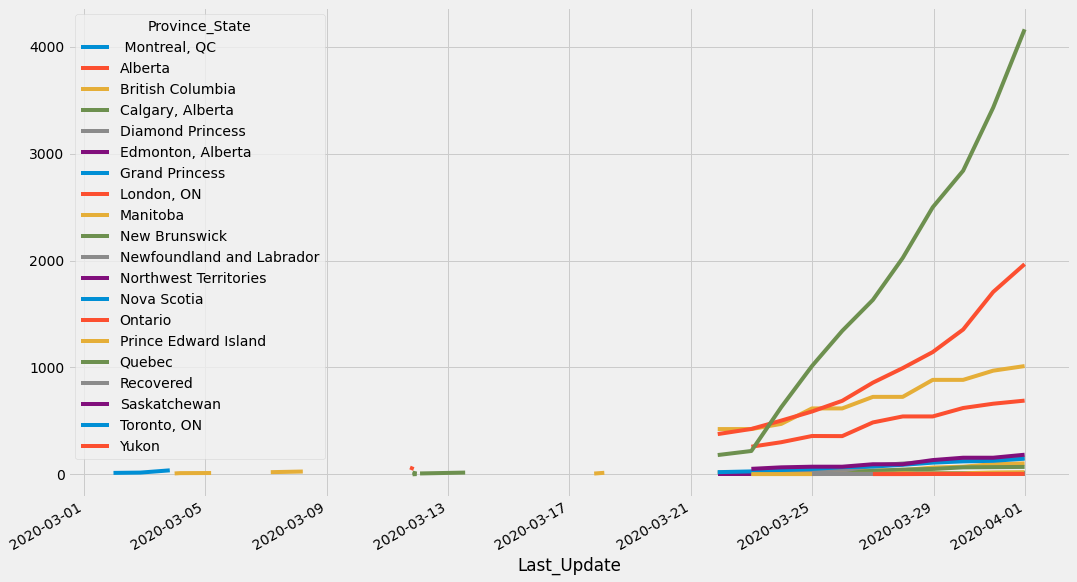

In [83]:
(df.loc[(df.Metric == 'Confirmed') & (df.Country_Region == 'Canada'), ['Province_State', 'Value']]
     .reset_index()     # make the index a column for now
     .pivot_table(index='Last_Update', columns='Province_State', values='Value', aggfunc=np.sum)
     .loc['2020-03':,:]
).plot()

In [42]:
piv = df.pivot_table(index=df.index, columns=['Metric','Combined_Key'], values='Value', aggfunc=np.sum)
piv.head() # Note the MultiIndex for the columns (Metric, Combined_Key)

Metric                             Active                                   \
Combined_Key         Montreal, QC, Canada  Norfolk County, MA, US ,,Belize   
Last_Update                                                                  
2020-02-01 19:53:03                   NaN                     NaN      NaN   
2020-02-03 03:53:02                   NaN                     NaN      NaN   
2020-02-05 21:53:02                   NaN                     NaN      NaN   
2020-02-08 03:43:03                   NaN                     NaN      NaN   
2020-02-09 19:03:03                   NaN                     NaN      NaN   

Metric                                                                      \
Combined_Key        ,,MS Zaandam ,,Mauritania ,Northern Mariana Islands,US   
Last_Update                                                                  
2020-02-01 19:53:03          NaN          NaN                          NaN   
2020-02-03 03:53:02          NaN          NaN                          NaN   
2020-02-05 21:53:02          NaN          NaN                          NaN   
2020-02-08 03:43:03          NaN          NaN                          NaN   
2020-02-09 19:03:03          NaN          NaN                          NaN   

Metric                                                                \
Combined_Key        ,Northwest Territories,Canada ,Virgin Islands,US   
Last_Update                                                            
2020-02-01 19:53:03                           NaN                NaN   
2020-02-03 03:53:02                           NaN                NaN   
2020-02-05 21:53:02                           NaN                NaN   
2020-02-08 03:43:03                           NaN                NaN   
2020-02-09 19:03:03                           NaN                NaN   

Metric                                                           ...  \
Combined_Key        ,Yukon,Canada Abbeville, South Carolina, US  ...   
Last_Update                                                      ...   
2020-02-01 19:53:03           NaN                           NaN  ...   
2020-02-03 03:53:02           NaN                           NaN  ...   
2020-02-05 21:53:02           NaN                           NaN  ...   
2020-02-08 03:43:03           NaN                           NaN  ...   
2020-02-09 19:03:03           NaN                           NaN  ...   

Metric                              Recovered                               \
Combined_Key        nan, United Arab Emirates nan, Uruguay nan, Uzbekistan   
Last_Update                                                                  
2020-02-01 19:53:03                       NaN          NaN             NaN   
2020-02-03 03:53:02                       NaN          NaN             NaN   
2020-02-05 21:53:02                       NaN          NaN             NaN   
2020-02-08 03:43:03                       NaN          NaN             NaN   
2020-02-09 19:03:03                       NaN          NaN             NaN   

Metric                                                              \
Combined_Key        nan, Vatican City nan, Venezuela nan, Viet Nam   
Last_Update                                                          
2020-02-01 19:53:03               NaN            NaN           NaN   
2020-02-03 03:53:02               NaN            NaN           NaN   
2020-02-05 21:53:02               NaN            NaN           NaN   
2020-02-08 03:43:03               NaN            NaN           NaN   
2020-02-09 19:03:03               NaN            NaN           NaN   

Metric                                                      \
Combined_Key        nan, Vietnam nan, Zambia nan, Zimbabwe   
Last_Update                                                  
2020-02-01 19:53:03          NaN         NaN           NaN   
2020-02-03 03:53:02          NaN         NaN           NaN   
2020-02-05 21:53:02          NaN         NaN           NaN   
2020-02-08 03:43:03          NaN      

In [38]:
# look at just the deaths (Metric == 'Deaths') aka the top level of the MultiIndex is 'Deaths'
idx = pd.IndexSlice
piv.loc[:,idx['Deaths']]

Combined_Key,"Montreal, QC, Canada","Norfolk County, MA, US",",,Belize",",,MS Zaandam",",,Mauritania",",Northern Mariana Islands,US",",Northwest Territories,Canada",",Virgin Islands,US",",Yukon,Canada","Abbeville, South Carolina, US",...,"nan, United Arab Emirates","nan, Uruguay","nan, Uzbekistan","nan, Vatican City","nan, Venezuela","nan, Viet Nam","nan, Vietnam","nan, Zambia","nan, Zimbabwe","nan, occupied Palestinian territory"
Last_Update,,,,,,,,,,,,,,,,,,,,,
2020-02-01 19:53:03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-03 03:53:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-05 21:53:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-08 03:43:03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-09 19:03:03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-31 23:31:54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-31 23:43:43,NaN,NaN,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-31 23:43:56,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
# Look at just deaths in California
# (must use columns.map() because you can't use .str.endswith on a MultiIndex)
piv.loc[:,idx['Deaths', piv.columns.map(lambda x: x[1].endswith('California, US'))]]

Metric                               Deaths                         \
Combined_Key        Alameda, California, US Alpine, California, US   
Last_Update                                                          
2020-02-01 19:53:03                     NaN                    NaN   
2020-02-03 03:53:02                     NaN                    NaN   
2020-02-05 21:53:02                     NaN                    NaN   
2020-02-08 03:43:03                     NaN                    NaN   
2020-02-09 19:03:03                     NaN                    NaN   
...                                     ...                    ...   
2020-03-31 23:31:54                     NaN                    NaN   
2020-03-31 23:43:43                     NaN                    NaN   
2020-03-31 23:43:56                     7.0                    NaN   
2020-03-31 23:49:13                     NaN                    NaN   
2020-03-31 23:49:27                     NaN                    NaN   

Metric                                                            \
Combined_Key        Amador, California, US Butte, California, US   
Last_Update                                                        
2020-02-01 19:53:03                    NaN                   NaN   
2020-02-03 03:53:02                    NaN                   NaN   
2020-02-05 21:53:02                    NaN                   NaN   
2020-02-08 03:43:03                    NaN                   NaN   
2020-02-09 19:03:03                    NaN                   NaN   
...                                    ...                   ...   
2020-03-31 23:31:54                    NaN                   NaN   
2020-03-31 23:43:43                    NaN                   NaN   
2020-03-31 23:43:56                    0.0                   0.0   
2020-03-31 23:49:13                    NaN                   NaN   
2020-03-31 23:49:27                    NaN                   NaN   

Metric                                                        \
Combined_Key        Calaveras, California, US California, US   
Last_Update                                                    
2020-02-01 19:53:03                       NaN            NaN   
2020-02-03 03:53:02                       NaN            NaN   
2020-02-05 21:53:02                       NaN            NaN   
2020-02-08 03:43:03                       NaN            NaN   
2020-02-09 19:03:03                       NaN            NaN   
...                                       ...            ...   
2020-03-31 23:31:54                       NaN            NaN   
2020-03-31 23:43:43                       NaN            NaN   
2020-03-31 23:43:56                       0.0            NaN   
2020-03-31 23:49:13                       NaN            NaN   
2020-03-31 23:49:27                       NaN            NaN   

Metric                                                                   \
Combined_Key        Colusa, California, US Contra Costa, California, US   
Last_Update                                                               
2020-02-01 19:53:03                    NaN                          NaN   
2020-02-03 03:53:02                    NaN                          NaN   
2020-02-05 21:53:02                    NaN                          NaN   
2020-02-08 03:43:03                    NaN                          NaN   
2020-02-09 19:03:03                    NaN                          NaN   
...                                    ...                          ...   
2020-03-31 23:31:54                    NaN                          NaN   
2020-03-31 23:43:43                    NaN                          NaN   
2020-03-31 23:43:56                    0.0                          3.0   
2020-03-31 23:49:13                    NaN                          NaN   
2020-03-31 23:49:27                    NaN                          NaN   

Metric                                                                   ...  \
Combined_Key        Del Norte, Califor